In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from glob import glob
import pickle

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


# 최대 사이즈 패딩

In [2]:
train_wav=glob('D:/dacon/covid19/data/train/*.wav')
test_wav=glob('D:/dacon/covid19/data/test/*.wav')


train_dict = dict()
test_dict = dict()


In [3]:
for path in train_wav:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 16 000HZ
    train_dict[file_name] = sig
    
for path in test_wav:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 16 000HZ
    test_dict[file_name] = sig

In [18]:
values = list(train_dict.values())

In [31]:
max_len=max([ val.shape[0]  for val in values])

In [36]:
max_len

243840

In [41]:
print("최대 사이즈 : ",max_len)

최대 사이즈 :  243840


In [42]:
for key in train_dict:
    sig = train_dict[key]
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,max_len)
    train_dict[key] = sig
    
    
for key in test_dict:
    sig = test_dict[key]
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,max_len)
    test_dict[key] = sig




In [86]:
#원본 시그널

 
## Save pickle
with open("D:/dacon/covid19/data/pickles/train_dict.pickle","wb") as fw:
    pickle.dump(train_dict, fw)

with open("D:/dacon/covid19/data/pickles/test_dict.pickle","wb") as fw:
    pickle.dump(test_dict, fw)
    


In [ ]:
#load
with open("D:/dacon/covid19/data/pickles/train_dict.pickle","rb") as fr:
    train_dict = pickle.load(fr)

with open("D:/dacon/covid19/data/pickles/test_dict.pickle","rb") as fr:
    test_dict = pickle.load(fr)

# 노 패딩 시그널

- 배치마다 실시.

In [3]:
train_wav=glob('D:/dacon/covid19/data/train/*.wav')
test_wav=glob('D:/dacon/covid19/data/test/*.wav')


train_dict = dict()
test_dict = dict()


In [4]:
for path in train_wav:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 16000HZ
    train_dict[file_name] = sig
    
for path in test_wav:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 16000HZ
    test_dict[file_name] = sig

In [5]:
for key in train_dict:
    sig = train_dict[key]
    train_dict[key] = sig
    
    
for key in test_dict:
    sig = test_dict[key]
    test_dict[key] = sig





In [6]:
#원본 시그널

 
## Save pickle
with open("D:/dacon/covid19/data/pickles/train_dict_nopad.pickle","wb") as fw:
    pickle.dump(train_dict, fw)

with open("D:/dacon/covid19/data/pickles/test_dict_nopad.pickle","wb") as fw:
    pickle.dump(test_dict, fw)
    


In [2]:
#load
with open("D:/dacon/covid19/data/pickles/train_dict_nopad.pickle","rb") as fr:
    train_dict = pickle.load(fr)

with open("D:/dacon/covid19/data/pickles/test_dict_nopad.pickle","rb") as fr:
    test_dict = pickle.load(fr)

In [9]:


spectro_mean=[]
spectro_std=[]

mel_mean=[]
mel_std=[]

mfcc_mean=[]
mfcc_std=[]


for key in train_dict.keys():
    #print(key)
    sig =  train_dict[key] # 16000hz 실시
    #length=29990 #300 padding을 위한 파라미터
    #pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    #sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    


    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)

    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    #print(value[0])
    spectro_mean.append(log_spectrogram.mean()) # spectrogram
    spectro_std.append(log_spectrogram.std()) # spectrogram
    
    #print(value[0])
    mel_mean.append(mel_feature.mean()) # spectrogram
    mel_std.append(mel_feature.std()) # spectrogram
    
    #print(value[0])
    mfcc_mean.append(MFCCs.mean()) # spectrogram
    mfcc_std.append(MFCCs.std()) # spectrogram    
    
    
    
    

print('spectro mean, std : ',np.mean(spectro_mean),np.mean(spectro_std))
print('mel mean, std : ',np.mean(mel_mean),np.mean(mel_std))
print('mfcc mean, std : ',np.mean(mfcc_mean),np.mean(mfcc_std))

spectro mean, std :  -13.326587 14.9956
mel mean, std :  -69.00234 15.334582
mfcc mean, std :  -2.653834 32.017303


In [4]:
train_dict

{'00001.wav': array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.3607033e-06,  9.0535781e-07, -7.7081609e-07], dtype=float32),
 '00002.wav': array([ 0.        ,  0.        ,  0.        , ..., -0.00011289,
        -0.00015794, -0.00019451], dtype=float32),
 '00003.wav': array([ 2.3494364e-09, -9.1116377e-09,  4.4755119e-08, ...,
         5.5032728e-05,  1.1036340e-04,  1.7972098e-04], dtype=float32),
 '00004.wav': array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.3850101e-05, -1.1712005e-04, -7.2017676e-05], dtype=float32),
 '00005.wav': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.6009955e-05,
        2.7185741e-05, 3.0722284e-05], dtype=float32),
 '00006.wav': array([0.        , 0.        , 0.        , ..., 0.00142012, 0.00140363,
        0.0017683 ], dtype=float32),
 '00007.wav': array([0.        , 0.        , 0.        , ..., 0.00043995, 0.00025011,
        0.00023942], dtype=float32),
 '00008.wav': array([0., 0., 0., ..., 0., 0

In [10]:
sigs=list(train_dict.values())

In [15]:
sigs[0].shape[0]

78720

In [16]:
sigs=[sig.shape[0] for sig in sigs]

In [17]:
np.max(sigs)

243840

원래 최대 사이즈로 패딩된것으로 의미가 없다.

# 길이 전처리

https://www.sciencedirect.com/science/article/pii/S0010482521003668?casa_token=PsIvQKZRT4YAAAAA:p_HvNmzFJoyB4B7rNDDfJ4p0QJl0XQEbsh1GOpLQ0Be0j9c7nbk-fObxXl0TQE6jLucrG9Iy4g

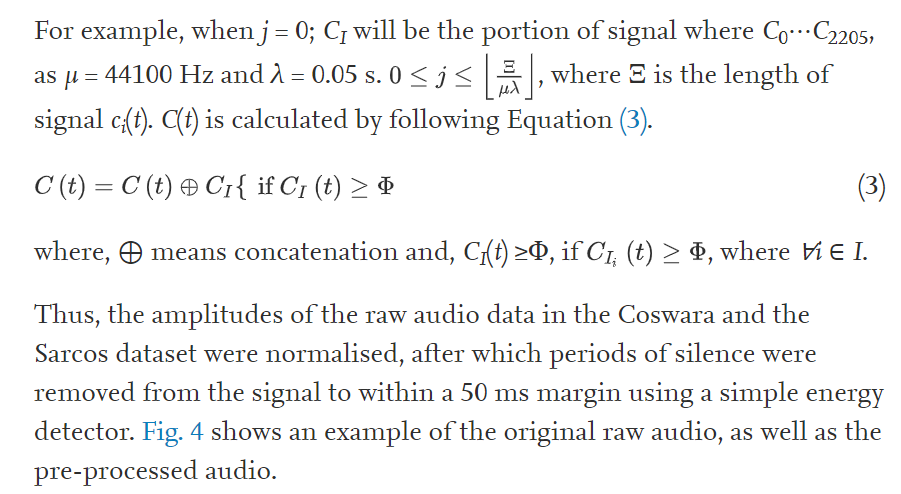

In [7]:
#load
with open("D:/dacon/covid19/data/pickles/train_dict_nopad.pickle","rb") as fr:
    train_dict = pickle.load(fr)

with open("D:/dacon/covid19/data/pickles/test_dict_nopad.pickle","rb") as fr:
    test_dict = pickle.load(fr)

In [11]:
train_dict['00001.wav'].shape[0]

78720

In [12]:


train_max = 0

train_size_list=[]

for key in train_dict.keys():
    #print(key)
    sig =  train_dict[key] # 16000hz 실시
    zero_val=np.abs((sig-sig.mean())/sig.std())>0.05
    train_dict[key] = sig[zero_val]
    train_size_list.append(train_dict[key].shape[0])
    train_max=max(train_max,train_dict[key].shape[0])


for key in test_dict.keys():
    #print(key)
    sig =  test_dict[key] # 16000hz 실시
    zero_val=np.abs((sig-sig.mean())/sig.std())>0.05
    test_dict[key] = sig[zero_val]
    #test_max=max(test_max,test_dict[key].shape[0])
    
    

In [14]:
train_max

158969

In [13]:
#원본 시그널

 
## Save pickle
with open("D:/dacon/covid19/data/pickles/train_dict_short.pickle","wb") as fw:
    pickle.dump(train_dict, fw)

with open("D:/dacon/covid19/data/pickles/test_dict_short.pickle","wb") as fw:
    pickle.dump(test_dict, fw)
    


In [16]:


spectro_mean=[]
spectro_std=[]

mel_mean=[]
mel_std=[]

mfcc_mean=[]
mfcc_std=[]


for key in train_dict.keys():
    #print(key)
    sig =  train_dict[key] # 16000hz 실시
    length=158969
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)    
    #length=29990 #300 padding을 위한 파라미터
    #pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    #sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    


    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)

    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    #print(value[0])
    spectro_mean.append(log_spectrogram.mean()) # spectrogram
    spectro_std.append(log_spectrogram.std()) # spectrogram
    
    #print(value[0])
    mel_mean.append(mel_feature.mean()) # spectrogram
    mel_std.append(mel_feature.std()) # spectrogram
    
    #print(value[0])
    mfcc_mean.append(MFCCs.mean()) # spectrogram
    mfcc_std.append(MFCCs.std()) # spectrogram    
    
    
    
    

print('spectro mean, std : ',np.mean(spectro_mean),np.mean(spectro_std))
print('mel mean, std : ',np.mean(mel_mean),np.mean(mel_std))
print('mfcc mean, std : ',np.mean(mfcc_mean),np.mean(mfcc_std))

spectro mean, std :  -14.566745103394913 14.420475879980572
mel mean, std :  -71.4706041723069 14.643695055175588
mfcc mean, std :  -2.7668411274554603 32.976804201005756
